In [8]:
# Comments give package versions at last run
%matplotlib inline
import matplotlib # version 3.4.3
import matplotlib.pyplot as plt
import seaborn as sns # version 0.11.2
import numpy as np # version 1.21.2
import pandas as pd # version 1.3.3
import os
import json
import new_utils

In [9]:
experiment_sets = [
    [
        'd75786f7-data-2018-01-25-big-experiment',
        '18a75a2d-data-2018-03-19-big-experiment',
    ],
    [
        '6b2b35f0-rounds-10-evidence-1-bit-experiment',
    ],
    [
        '095ddcbc-rounds-10-evidence-4-big-experiment-high-prob',
    ],
    [
        'b7d0390f-rounds-10-evidence-4-population-5',
        'abf00068-rounds-10-evidence-4-population-5',
    ],
    [
        '70f80fdf-rounds-10-evidence-1-population-5',
        'd9145d2a-rounds-10-evidence-1-population-5',
    ]
]

In [10]:
names = ['Experiment-1',
         'Experiment-2',
         'Experiment-3',
         'Experiment-4',
         'Experiment-5',
         ]



sizes = [20,20,20,5,5]
n_evidences = [4,1,4,4,1]
part_probs = [0.6, 0.6, 0.8, 0.6, 0.6]

In [11]:
df = None

for exp in range(len(experiment_sets)):

    exp_name = names[exp]
    gen_size = sizes[exp]
    n_evidence = n_evidences[exp]
    part_prob = part_probs[exp]

    for in_dir in experiment_sets[exp]:

        data,fails,parts = new_utils.get_data(in_dir, n_evidence)
        new_df = new_utils.get_parsed_data(data, fails, parts, part_prob, in_dir)
        new_df['Experiment'] = exp
        new_df['Gen Size'] = gen_size
        new_df['Num Evidence'] = n_evidence
        new_df['Part Probability'] = part_prob
        if df is None:
            df = new_df
        else:
            df = pd.concat([df, new_df])

199 21
Total participants: 200
200 8
Total participants: 200
200 16
Total participants: 200
200 24
Total participants: 200
50 0
Total participants: 50
50 5
Total participants: 50
50 3
Total participants: 50
50 3
Total participants: 50


In [12]:
models = [
    'Naive Copying',
    'Social Sampling (Probability Matching)',
    'Social Sampling (Bayesian)'
]

pos_p = df['Part Probability']
neg_p = 1 - df['Part Probability']

evidence = df['Last Evidence'] * df['Num Evidence']

df['Naive Copying'] = df['last_pops']

last = df['Last Evidence']
last_pop = df['last_pops']

df['Social Sampling (Probability Matching)'] = last_pop * last / (last_pop*last + (1-last_pop)*(1 - last))
df['Social Sampling (Probability Matching)'] = df['Social Sampling (Probability Matching)'].fillna(0)

social_post_match = last_pop * pos_p ** evidence * (1 - pos_p) ** (df['Num Evidence'] - evidence)
social_post_match /= (social_post_match + (1 - last_pop) * neg_p ** evidence * (1 - neg_p) ** (df['Num Evidence'] - evidence))
df['Social Sampling (Bayesian)'] = social_post_match

In [13]:
df.to_csv('data.csv')
os.system('Rscript nhb-r1-analysis.R > tmp')
with open('tmp') as f:
    print(''.join(f.readlines()))


Call:
lm(formula = Popularity ~ Total.Evidence + Last.Evidence + factor(Experiment) + 
    factor(Game.Net), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63296 -0.11521 -0.00616  0.11684  0.68432 

Coefficients: (4 not defined because of singularities)
                                                                          Estimate
(Intercept)                                                               0.294710
Total.Evidence                                                            0.052269
Last.Evidence                                                             0.245841
factor(Experiment)1                                                       0.032488
factor(Experiment)2                                                      -0.011698
factor(Experiment)3                                                       0.010894
factor(Experiment)4                                                       0.121556
factor(Game.Net)095ddcbc-rounds-10-evidence-4-big-exper


Condition 1

Correlation: 0.4290508451508649

Naive Copying MSE: 0.0433203125000001
Social Sampling (Probability Matching) MSE: 0.05420850681339347
Social Sampling (Bayesian) MSE: 0.0366441819896114
N 576

Condition 2

Correlation: 0.3875057629593951

Naive Copying MSE: 0.04238462796244996
Social Sampling (Probability Matching) MSE: 0.1703068973145584
Social Sampling (Bayesian) MSE: 0.033287261263396845
N 288

Condition 3

Correlation: 0.6463605140149422

Naive Copying MSE: 0.03713541666666663
Social Sampling (Probability Matching) MSE: 0.08250129765608755
Social Sampling (Bayesian) MSE: 0.11875653039414288
N 288

Condition 4

Correlation: 0.28945351228452354

Naive Copying MSE: 0.10784722222222158
Social Sampling (Probability Matching) MSE: 0.106941609738604
Social Sampling (Bayesian) MSE: 0.09694245816700221
N 576

Condition 5

Correlation: 0.16373998862405495

Naive Copying MSE: 0.10298611111111042
Social Sampling (Probability Matching) MSE: 0.21958333333333294
Social Sampling (Bay

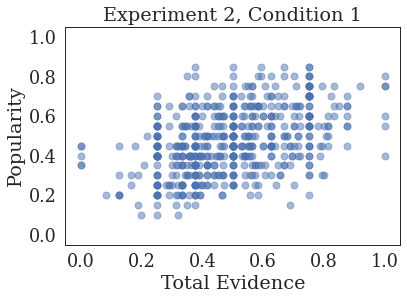

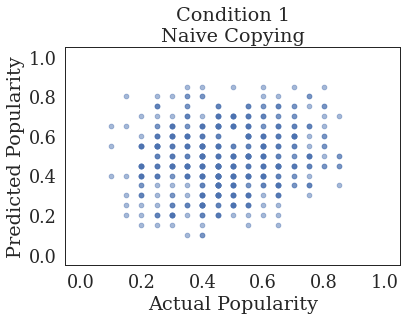

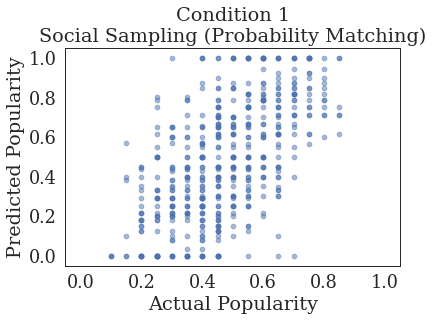

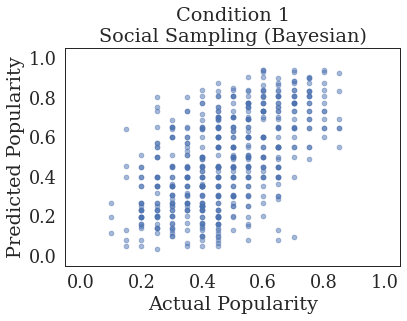

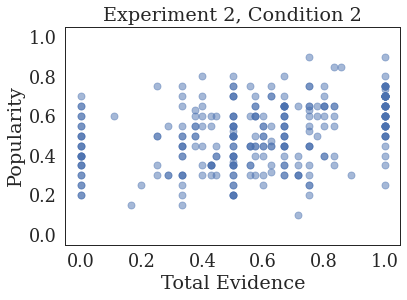

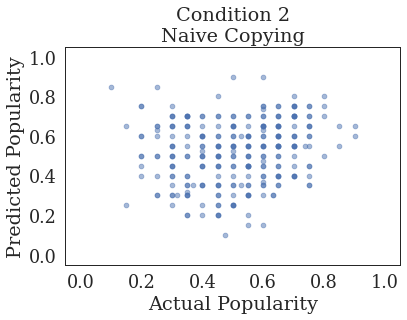

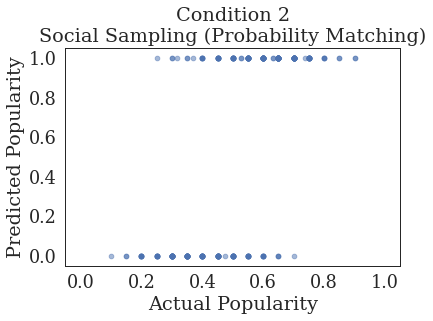

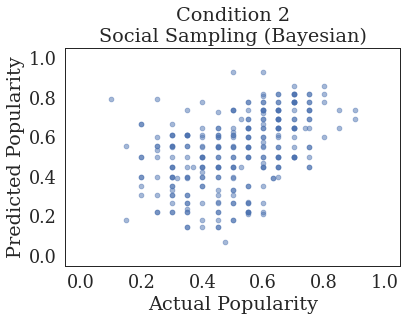

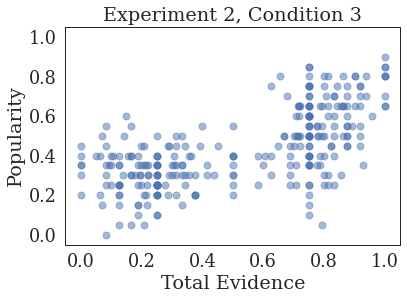

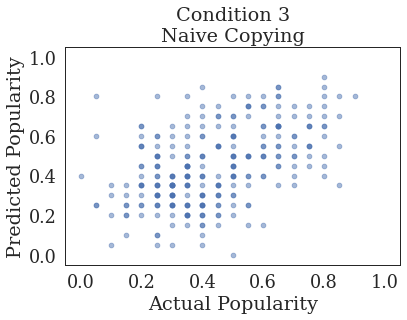

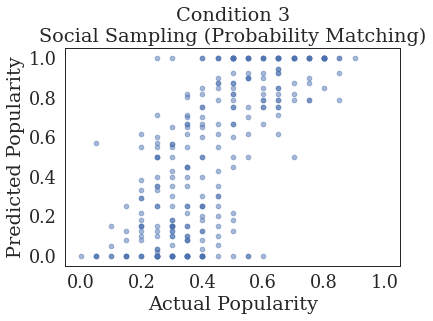

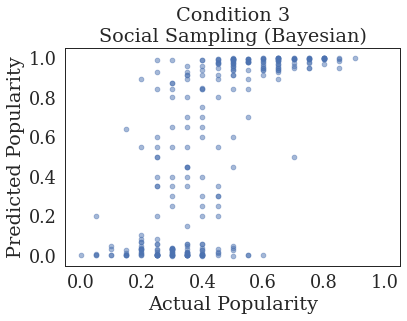

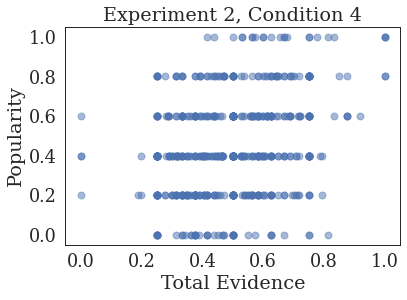

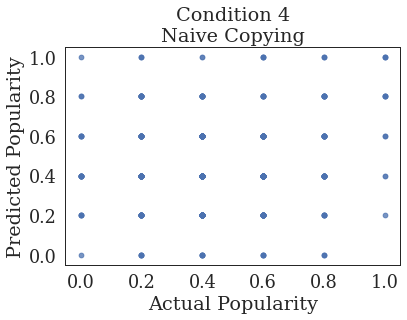

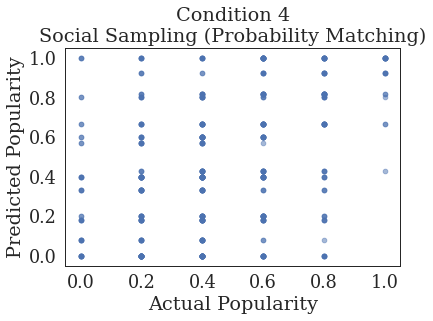

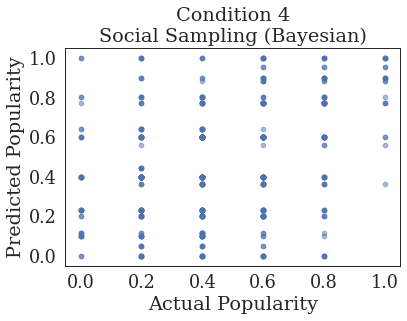

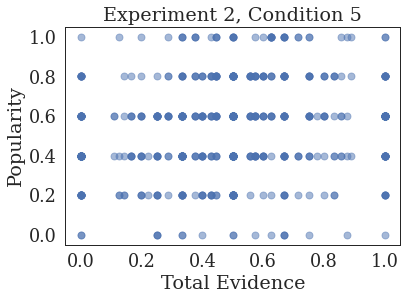

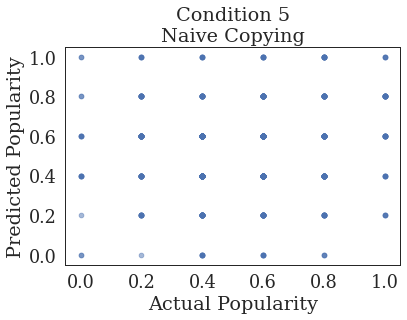

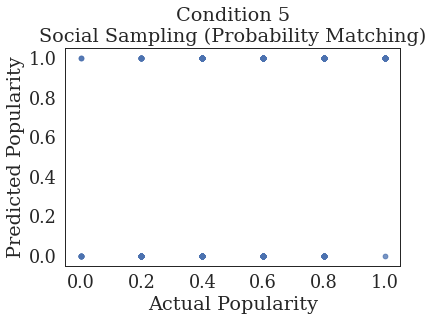

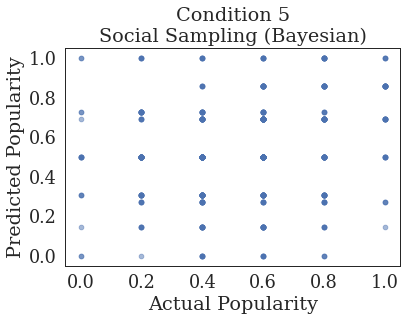

In [14]:
for exp in range(len(experiment_sets)):
    
    sub_df = df.loc[df['Experiment'] == exp]

    plt.figure()
    sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')
    plt.scatter(sub_df['Total Evidence'],sub_df['Popularity'], s = 50, alpha = 0.5)
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.xlabel('Total Evidence')
    plt.ylabel('Popularity')
    plt.title('Experiment 2, Condition ' + str(exp+1))
    plt.savefig('plots/exp-2-' + str(exp) + '-evi-pop.pdf', bbox_inches='tight')
    
    print()
    print('Condition', exp+1)
    print()
    print('Correlation:', np.corrcoef(sub_df['Total Evidence'],sub_df['Popularity'])[0,1])
    print()
    for m in models:
        print(m, 'MSE:', sum((sub_df[m] - sub_df['Popularity'])**2) / len(sub_df))
    print('N',len(sub_df))
    
    for m in models:
        plt.figure()
        plt.scatter(sub_df['Popularity'], sub_df[m], alpha = 0.5)
        plt.xlim(-0.05,1.05)
        plt.ylim(-0.05,1.05)
        plt.ylabel('Predicted Popularity')
        plt.xlabel('Actual Popularity')
        plt.title('Condition ' + str(exp+1) + '\n' + m)
        plt.savefig('plots/exp-2-' + str(exp) + '-' + '-'.join(m.split(' ')) + '.pdf', bbox_inches='tight')